In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [3]:
#read the data
zf = zipfile.ZipFile('/content/train.csv.zip')
df = pd.read_csv(zf.open('train.csv'))
#looking at the data
df.head()



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
 df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
 df.iloc[12][df.columns[2:]]

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: object

In [6]:
x=df['comment_text'].values
y=df[df.columns[2:]].values


#  **Preprocessing**

In [7]:
from tensorflow.keras.layers import TextVectorization
max_len=200000 # num of words in vocab
vectorizer=TextVectorization(max_tokens=max_len,
                            output_sequence_length=1000,
                            output_mode='int')

In [8]:
vectorizer.adapt(x)

In [9]:
vectorized_text=vectorizer(x)
vectorized_text


<tf.Tensor: shape=(159571, 1000), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [10]:
data=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
data=data.cache()
data=data.shuffle(160000)
data=data.batch(16)
data=data.prefetch(8)

In [11]:
train=data.take(int(len(data)*0.7))
val=data.skip(int(len(data)*0.7)).take(int(len(data)*0.2))
test=data.skip(int(len(data)*0.9)).take(int(len(data)*0.1))

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,Embedding,Dense

In [13]:
model=Sequential()
model.add(Embedding(max_len+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))


In [14]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam' ,metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [25]:
history=model.fit(train,epochs=10,validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 423s 61ms/step - loss: 0.0463 - accuracy: 0.9942 - val_loss: 0.0413 - val_accuracy: 0.9940
Epoch 2/10
6981/6981 [==============================] - 416s 60ms/step - loss: 0.0417 - accuracy: 0.9889 - val_loss: 0.0373 - val_accuracy: 0.9942
Epoch 3/10
6981/6981 [==============================] - 410s 59ms/step - loss: 0.0374 - accuracy: 0.9943 - val_loss: 0.0330 - val_accuracy: 0.9941
Epoch 4/10
6981/6981 [==============================] - 411s 59ms/step - loss: 0.0347 - accuracy: 0.9918 - val_loss: 0.0329 - val_accuracy: 0.9915
Epoch 5/10
6981/6981 [==============================] - 409s 59ms/step - loss: 0.0313 - accuracy: 0.9934 - val_loss: 0.0279 - val_accuracy: 0.9933
Epoch 6/10
6981/6981 [==============================] - 411s 59ms/step - loss: 0.0281 - accuracy: 0.9922 - val_loss: 0.0245 - val_accuracy: 0.9938
Epoch 7/10
6981/6981 [==============================] - 410s 59ms/step - loss: 0.0255 - accuracy: 0.9844 - val_loss: 0

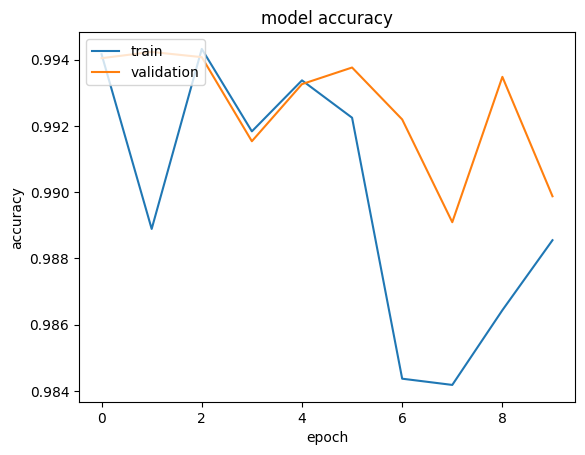

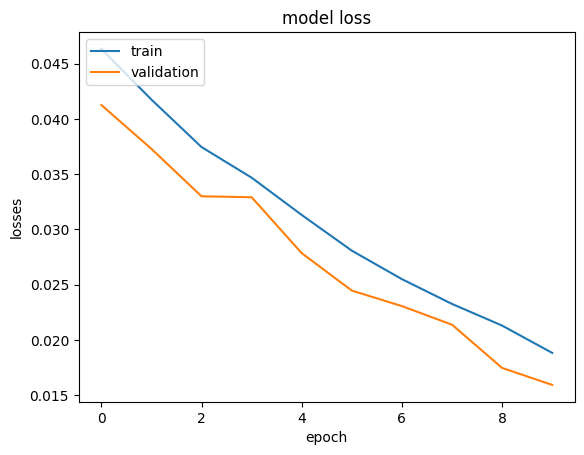

In [34]:
def plot(A, B):
  plt.plot(A)
  plt.plot(B)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

# summarize history for accuracy
plot(history.history['accuracy'], history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.show()

# summarize history for loss
plot(history.history['loss'], history.history['val_loss'])
plt.title('model loss')
plt.ylabel('losses')
plt.show()



# **prediction**

In [27]:
batch_x, batch_y=test.as_numpy_iterator().next()

In [28]:

 (model.predict(batch_x)>0.5).astype(int)

1/1 [==============================] - 0s 45ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# **Evaluation**

In [30]:
from tensorflow.keras.metrics import Precision, Recall

In [31]:
pre =Precision()
re= Recall()



In [32]:
for batch in test.as_numpy_iterator():
  x_true, y_true =batch
  yhat = model.predict(x_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)






1/1 [==============================] - 0s 60ms/step


In [36]:
print(f'Precision: {pre.result().numpy()},Recall: {re.result().numpy()}')

Precision: 0.908108115196228,Recall: 0.9201499223709106


# **Test and Gradio**

In [ ]:
!pip install gradio jinja2

In [38]:
import gradio as gr

In [40]:
model.save('toxicity.h5')

In [41]:
model=tf.keras.models.load_model('toxicity.h5')

In [42]:
model=tf.keras.models.load_model('toxicity.h5')

In [75]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:8]):
    text += '{}: {}\n' .format(col, results[0][idx]>0.5)

  return text

In [76]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(),
                         outputs='text',)

In [77]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5aaa62b2bff6693d2b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
